# TP 2

In [16]:
import numpy as np
import numpy.random 
import matplotlib.pyplot as plt
import numpy.linalg

Implémentation du filtre de Kalman pour la dynamique donnée :

Constantes

In [17]:
delta_t = 1
c=2
m_0 = np.array([5000,5000,-20,20])
P_0 = np.diag([2000**2,2000**2,5**2,5**2])
F = np.array([[1,0,delta_t,0],[0,1,0,delta_t],[0,0,1,0],[0,0,0,1]])
G = np.array([[c*delta_t**2/2,0],[0,c*delta_t**2/2],[delta_t*c,0],[0,delta_t*c]])
N=200
T=N*delta_t
S = np.array([[50,0],[0,50]])
R= S*S

Simulation de la dynamique

In [4]:
def tirage_X_0(m_0,P_0):
    Normale_centree_reduite = np.random.normal(size=4)
    X_0 = m_0 + np.dot(np.sqrt(P_0),Normale_centree_reduite)
    return(X_0)

def dynamique(delta_t,N,m_0,P_0):
    X_0 = tirage_X_0(m_0,P_0)
    X=[X_0]
    for i in range(N):
        w= np.random.normal(0,1,2)
        X.append(np.dot(F,X[-1])+np.dot(G,w))
    return(np.array(X))

Calcul d'une trajectoire

In [34]:
X = dynamique(delta_t,N,m_0,P_0)
np.save('dyn',X)

Tracé d'une trajectoire

----------position---------



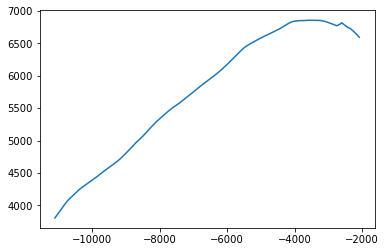

---------vitesse---------



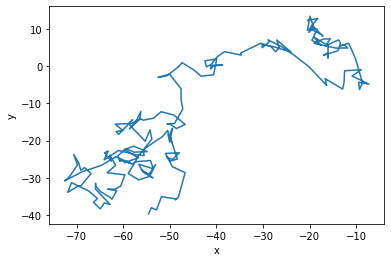

In [35]:
print("----------position---------\n")
plt.plot(X[:,0],X[:,1])
plt.show()
print("---------vitesse---------\n")
plt.plot(X[:,2],X[:,3])
plt.xlabel("x")
plt.ylabel('y')
plt.show()


In [7]:
def fonction_d_observation(x,S): #x est un array 1*2
    bruit_gaussien = np.dot(S,np.random.normal(0,1,2))
    return(x+bruit_gaussien)

fonction_d_observation(X[:,:2][6],S)


array([3535.76930944, 6428.48380562])

filtre de Kalman

In [22]:
H = np.array([[1,0,0,0],[0,1,0,0]])

def Kalman(delta_t,S,X): 
    """X est la dynamique et Y sont les observations"""
    n,p = np.shape(X)
    X_k_k=[m_0]
    P_k_k = [P_0]
    X_k_k_1 = []
    P_k_k_1 = []
    K_k = [] # gain de kamlan
    for i in range(1,n) : 
        # print("etape "+ str(i))
        # print('prediction')
        # prediction
        X_k_k_1.append(np.dot(F,X_k_k[-1]))
        FP = np.dot(F,P_k_k[-1])
        FPF = np.dot(FP,F.T)
        GGT = np.dot(G,G.T)
        P_k_k_1.append(FPF+GGT)
        # print('correction')
        # correction
        PH = np.dot(  P_k_k_1[-1],  H.T)
        HP = np.dot(  H,P_k_k_1[-1])
        HPHT = np.dot(HP,H.T)
        inverse = np.linalg.inv( HPHT +  R)
        K_k.append(np.dot(PH,inverse))  
        P_k_k.append( np.dot( (np.identity(4)-np.dot(K_k,H)) , P_k_k_1[-1] )[0])
        Y_k = fonction_d_observation(X[:,:2][i],S)
        X_k_k.append( (X_k_k_1[-1] +np.dot( K_k, Y_k - np.dot( H, X_k_k_1[-1])))[0])
        # print(np.shape(X_k_k[-1]))
    return(np.array(X_k_k),np.array(P_k_k))


def kalman2(delta_t,S,X):
    n,p = np.shape(X)
    q,r = np.shape(P_0)
    X_k = np.zeros((n,p))
    P_k = np.zeros((n,q,r))
    X_k_ = np.zeros((n,p))
    P_k_ = np.zeros((n,q,r))
    K_k = np.zeros((n,p,2))  #2 c'est la dimension de l'observation
    X_k[0]=m_0 
    P_k[0]=P_0
    for i in range(1,n):
        # prediction
        X_k_[i] = np.dot(F,X_k[i-1]) 
        FP = np.dot(F,P_k[i-1])
        FPFT = np.dot(FP,F.T)
        P_k_[i] = FPFT+np.dot(G,G.T)
        # correction
        PHT = np.dot(  P_k_[i],  H.T)
        HP = np.dot(  H,P_k_[i])
        HPHT = np.dot(HP,H.T)
        inverse = np.linalg.inv( HPHT +  R)
        K_k[i] = np.dot(PHT,inverse)
        Y_k = fonction_d_observation(X[:,:2][i],S)
        X_k[i]=X_k_[i]+np.dot( K_k[i], Y_k - np.dot( H, X_k_[i]))
        P_k[i] = np.dot( (np.identity(4)-np.dot(K_k[i],H)) , P_k_[i] )
    return(X_k,P_k)




In [36]:
X_k,P_k = kalman2(delta_t,S,X)
covariance_position = P_k[:,:2,:2]

In [38]:
with open('kalman.npy','wb') as f : 
    np.save(f,X_k)
covariance_position = P_k[:,:2,:2]
with open('cov.npy','wb') as f : 
    np.save(f,covariance_position)

In [10]:
def plot_cov(cov, mean=[0, 0], cst=6, num=200):
    """Display the ellipse associated to the covariance matrix cov.
    If mean is specified, the ellipse is translated accordingly.
    """
    cov = np.linalg.inv(np.asarray(cov))
    mean = np.asarray(mean)
    theta = np.linspace(0, 2*np.pi, num=num)
    X = np.c_[np.cos(theta), np.sin(theta)]
    X = X.T * np.sqrt(cst / np.diag(X.dot(cov.dot(X.T))))
    X = X.T + mean
    plt.plot(X[:, 0], X[:, 1], 'r')

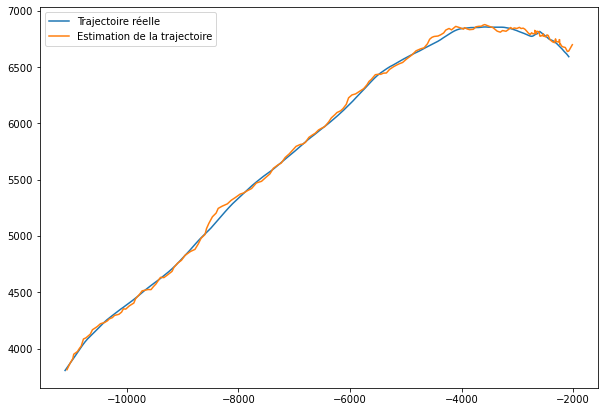

In [37]:
n,p = np.shape(X_k)
plt.figure(figsize = (10,7))
plt.plot(X[:,0],X[:,1])
plt.plot(X_k[1:,0],X_k[1:,1])
plt.legend(["Trajectoire réelle","Estimation de la trajectoire"])
plt.show()

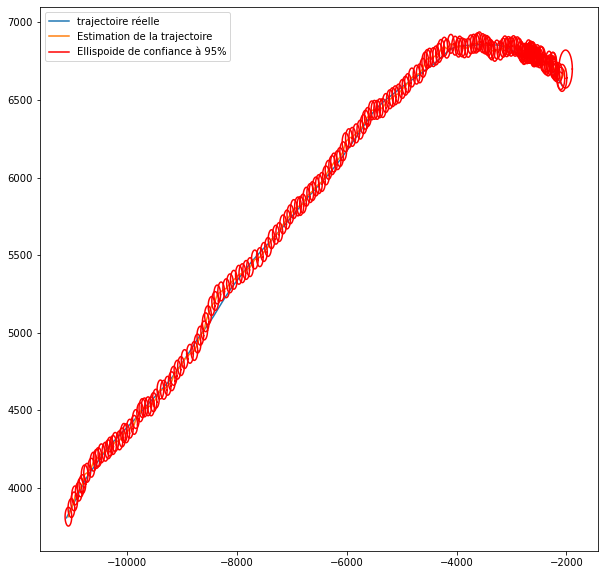

In [39]:
n,p = np.shape(X_k)
plt.figure(figsize = (10,10))
plt.plot(X[:,0],X[:,1])
plt.plot(X_k[1:,0],X_k[1:,1])
for i in range(1,n):
    plot_cov(covariance_position[i],X_k[i,:2],cst = 6)
plt.legend(["trajectoire réelle","Estimation de la trajectoire","Ellispoide de confiance à 95%"])
plt.show()